# Models VIII: Multiple Categorical Predictors & ANOVA

Let's keep working with the *poker dataset* from the previous notbook and explore models with **multiple categorical variables**

The experiments used a 2 (skill) x 3 (hand) x 2 (limit) design

| Variable   | Description                     |
|------------|---------------------------------|
| skill     | a player's skill (expert/average)|
| hand     | the quality of the hand experimenters manipulate (bad/neutral/good)|
| limit     | the style of game (fixed/no-limit)|
| balance     | a player's final balance in Euros|

### Slides for reference

[Modeling VII](https://stat-intuitions.com/lectures/wk8/1.html)

In [2]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Load data
df = pl.read_csv('./data/poker-tidy.csv')

In [3]:
# Calculate means of each level
bad = df.filter(col('hand') == 'bad')['balance'].mean()
good = df.filter(col('hand') == 'good')['balance'].mean()
neutral = df.filter(col('hand') == 'neutral')['balance'].mean()

means = np.array([bad, good, neutral])

# And the grand-mean
grand_mean = means.mean()

## Review: One-way ANOVA

Previously we estimated the model: $$balance \sim hand$$ where $hand$ had 3 levels: $bad$, $neutral$ and $good$

By using the `anova_lm()` function we can perform an F-test to see if adding `skill` to the model is *worth it* relative to a model with just an intercept. This doesn't test *which levels* of `skill` are different, just whether including `skill` in the model make a difference in our ability to predict `balance`.

And we observe that it is: F(2,297) = 75.70, p < .001

In [5]:
one_way = ols('balance ~ C(hand)', data=df.to_pandas())
one_way_results = one_way.fit()

anova_lm(one_way_results, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,3530.142225,1.0,208.830766,3.272007e-36
C(hand),2559.401402,2.0,75.702581,2.699281e-27
Residual,5020.583223,297.0,NaN,NaN


We also learned that for any categorical predictor with *k-levels* (k = 3 for `hand`), we can represent in our GLM represents it using *k-1 parameters* (2 betas for `hand`) depending on a variety of **coding schemes** with different parameter interpretations. And yet all of these yield the same F-test...

The same **One-way ANOVA** results

1. **Treatment (Dummy) Coding**
  - Default coding scheme
  - Intercept = reference level
  - Other parameters = differences from reference level


In [6]:
treatment = ols('balance ~ C(hand)', data=df.to_pandas()).fit()
treatment.params

Intercept             5.9415
C(hand)[T.good]       7.0849
C(hand)[T.neutral]    4.4051
dtype: float64

In [7]:
print(f"Intercept = Bad mean {bad:.3f}")
print(f"B1 = Good - Bad {good - bad:.3f}")
print(f"B2 = Neutral - Bad {neutral - bad:.3f}")

Intercept = Bad mean 5.941
B1 = Good - Bad 7.085
B2 = Neutral - Bad 4.405


2. **Deviation (Sum) Coding**
  - Intercept = grand-mean
  - Other parameters = differences from grand-mean


In [8]:
sums = ols('balance ~ C(hand, Sum)',data=df.to_pandas()).fit()
sums.params

Intercept               9.7715
C(hand, Sum)[S.bad]    -3.8300
C(hand, Sum)[S.good]    3.2549
dtype: float64

In [9]:
print(f"Intercept = Grand mean {grand_mean:.3f}")
print(f"B1 = Bad - Grand mean {bad - grand_mean:.3f}")
print(f"B2 = Good - Grand mean {good - grand_mean:.3f}")


Intercept = Grand mean 9.771
B1 = Bad - Grand mean -3.830
B2 = Good - Grand mean 3.255


3. **Orthogonal (Polynomial) Coding**
  - Intercept = grand-mean
  - Other parameters = trends across levels (e.g. linear, quadratic, cubic)


In [10]:
polys = ols('balance ~ C(hand, Poly)',data=df.to_pandas()).fit()
polys.params

Intercept                  9.771500
C(hand, Poly).Linear       3.114876
C(hand, Poly).Quadratic   -3.986422
dtype: float64

In [9]:
# Approximately the linear contrast Poly uses
lin_con = np.dot([-.707, 0, .707], means)

# Approximately the quadratic contrast Poly uses
quad_con = np.dot([.408, -.816, .408], means)

print(f"Intercept = Grand mean {grand_mean:.3f}")
print(f"Linear contrast = {lin_con:.3f}")
print(f"Quadratic contrast = {quad_con:.3f}")

Intercept = Grand mean 9.771
Linear contrast = 3.114
Quadratic contrast = -3.984


## Multiple Categorical Predictors

In the original study the authors also had players of different `skill` levels participant: $expert$ and $average$ players. 

Let's extend our model to test if this additional information is *worth* adding to our model and whether we need to think more carefully about the *coding* scheme we're using... 

Let's do some visual inspection to look at the effects of `hand` and `skill` and their interction:


### Challenge

Make 3 boxplot figures all of which plot `balance` on the y-axis and:
1. `hand` on the x-axis ("main effect" of hand)
2. `skill` on the x-axis and on `hue` ("main effect" of skill)
3. `hand` on the x-axis and `skill` on the `hue` ("interaction" of hand and skill)

1. The effect of `hand` we estimated in the one-way ANOVA above:

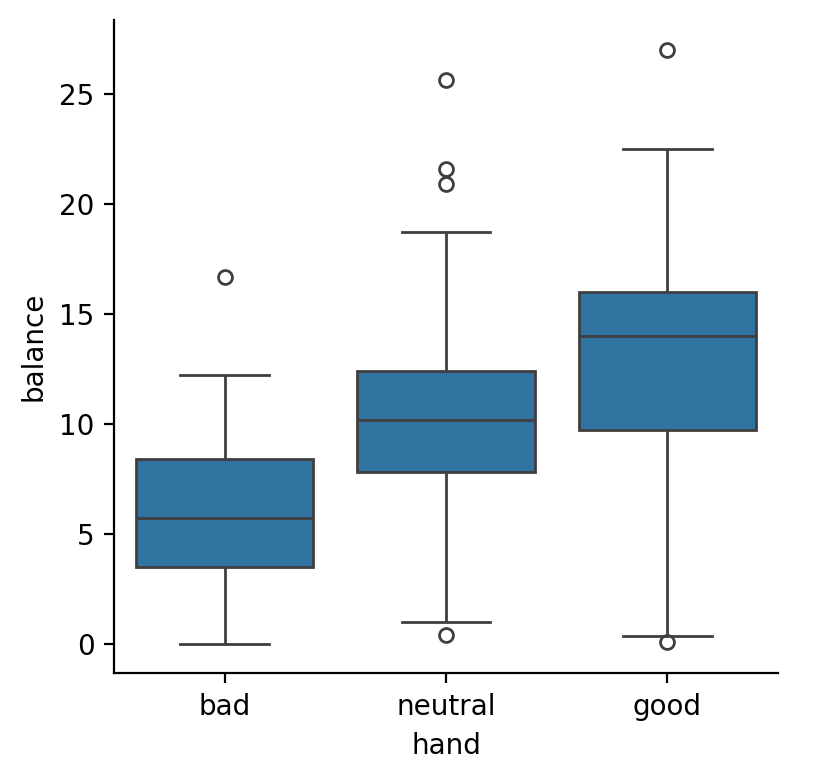

In [12]:
# Solution
grid = sns.catplot(data=df, x='hand', y='balance',kind='box',height=4)

2. The effect of `skill`

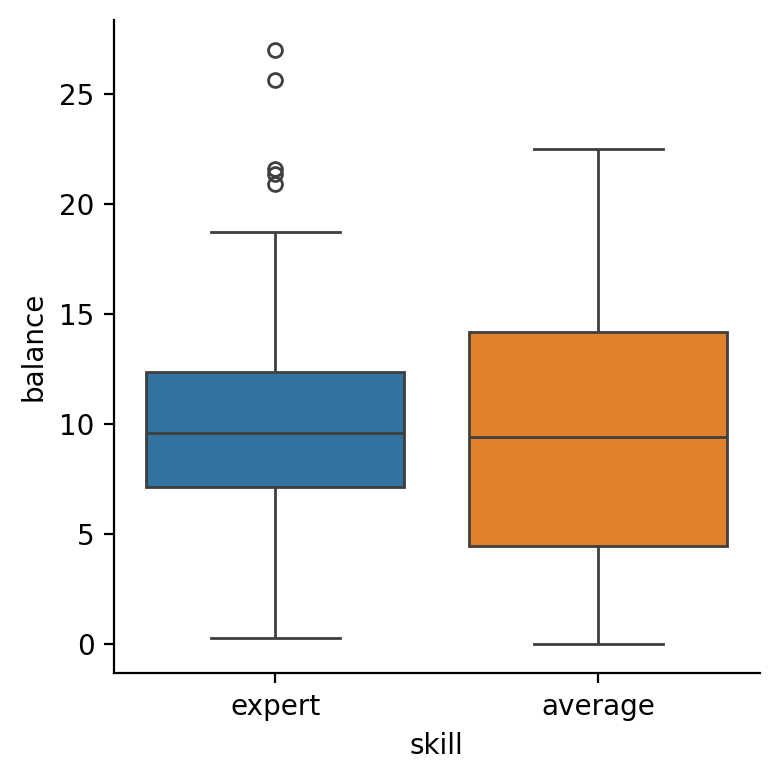

In [ ]:
# Solution
grid = sns.catplot(data=df, x='skill', y='balance', hue='skill', kind='box',height=4)

3. The *interaction* between them, which we can think of as either:
- the difference between `skill` levels at each level of `hand`
- the difference between `hand` levels at each level of `skill`

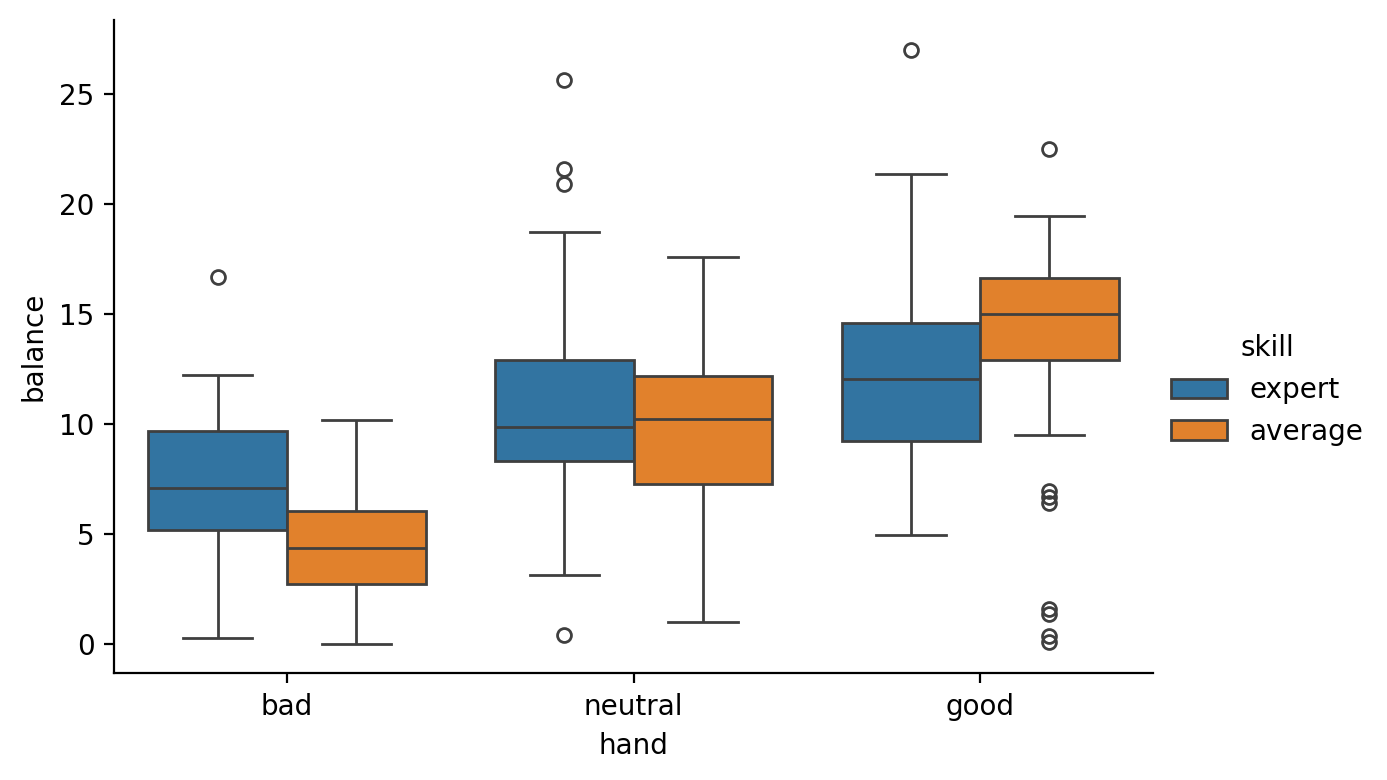

In [14]:
# Solution
grid = sns.catplot(data=df, x='hand', y='balance',hue='skill', kind='box', height=4, aspect=1.5)

After some visual inspection of the figures it looks like the best way to incorporate additional information about a player's `skill` is to estimate a model that includes an **interaction** between `hand` and `skill`. Why? Because it looks like the differences between `bad`, `good`, and `neutral` hands are *different* for `expert` vs `average` players

### Challenge
Fit 2 new models that estimate $$balance \sim hand * skill $$

- For one of the models using the default *treatment* coding.  
- For the other model use *sum* coding

Use `anova_lm(your_model, type=3)` to inspect the F-table for each model *separately*.  

For which model to the results make sense with respect to the figures you made above?

*Your response here*

In [15]:
# Solution
twoway_treatment = ols('balance ~ C(hand) * C(skill)', data=df.to_pandas()).fit()

anova_lm(twoway_treatment,typ=3).round(4)

,sum_sq,df,F,PR(>F)
Intercept,1051.8450,1.0,65.0728,0.0000
C(hand),2135.2201,2.0,66.0481,0.0000
C(skill),183.5754,1.0,11.3570,0.0009
C(hand):C(skill),228.9817,2.0,7.0830,0.0010
Residual,4752.2521,294.0,NaN,NaN


In [16]:
# Solution
twoway_sums = ols('balance ~ C(hand,Sum) * C(skill, Sum)', data=df.to_pandas()).fit()

anova_lm(twoway_sums, typ=3).round(4)

,sum_sq,df,F,PR(>F)
Intercept,28644.6637,1.0,1772.1137,0.0000
"C(hand, Sum)",2559.4014,2.0,79.1692,0.0000
"C(skill, Sum)",39.3494,1.0,2.4344,0.1198
"C(hand, Sum):C(skill, Sum)",228.9817,2.0,7.0830,0.0010
Residual,4752.2521,294.0,NaN,NaN


## Two-way Factorial ANOVA

You should have noticed that using the *treatment* coding scheme made it seem like the effect of `skill` was *also* significant even though $expert$ and $average$ players clearly don't look different from the figure above. So what's going on?

It turns out that ***how* we code categorical matters for valid F-tests in multiple regression**.  

In fact this type of multiple regression has a special name, it's called a **factorial ANOVA (analysis of variance)**.

|    | Expert | Average |
|----|--------|---------|
| **Bad** | hand = bad, skill = expert   | hand = bad, skill = average |
| **Neutral** | hand = neutral, skill = expert | hand = neutral, skill = average |
| **Good** | hand = good, skill = expert | hand = good, skill = average |

ANOVA is a statistical process initially [developed by Ronald Fisher in 1925](https://higherlogicdownload.s3.amazonaws.com/AMSTAT/1484431b-3202-461e-b7e6-ebce10ca8bcd/UploadedImages/Classroom_Activities/HS_8__FISHER_and_Design_of_experiments.pdf), for analyzing experiments with *only* categorical *factors*. ANOVA provides a mathematical "trick" we can use to efficiently calculate the *change in a model's residual variance* attributable to each factor - in the table above the first factor `hand` had 3 levels and the second factor `skill` had 2 levels. 

ANOVA allows us to decompose this variance to test *joint-hypotheses* - are *all the parameters* encoding *all the levels* of `skill` (or `hand`) *worth it?* For this reason we often refer to an F-test as an **omnibus test** because it tests all of the parameters encoding a factor at once.

 We've seen this "change in residual variance" before - it's the **Proportional Reduction in Error (PRE)** when we compare nested models! In fact the **F-distribution** is named in honor of Ronald Fisher - and describes how this change in variance changes as we have more/less factor levels and observations. 


<div align="center">
<img src="./figs/fstat-pre.png" width="60%" alt="Figure 1">
</div>



However, in order to use this trick and calculate ANOVA correctly there are several **key requirements**:
- We have to use a valid **contrast** coding scheme for our categorical variable
- We have to calculate our sum-of-squared residuals using the "type III approach"

There are certain situations in which these conditions won't matter as much (e.g. perfectly balanced data and factor levels) - but in practice you should follow the guidelines above whenever you plan to conduct F-tests using multiple categorical predictors.

Let's take a look at each of these now

### Valid Contrast coding schemes

You should refer to this week's reading, especially Chapter 8 of Data Analysis: A Model Comparison Approach, for more additional background details, but in general we consider a categorical coding scheme to be a valid **contrast scheme** if using values if 2 conditions are met:
- If the codes within each column sum-to-zero
- If overall-sum of codes across columns equals zero

This ensure that our comparisons are orthogonal to each other and yields valid "main effect" and "interaction" F-tests from our ANOVA. 

Let's see the difference between *treatment* and *sum* coding:

In [17]:
from helpers import plot_design_matrix

We can see that the *treatment/dummy* coding using 0s and 1s and therefore doesn't meet these conditions:

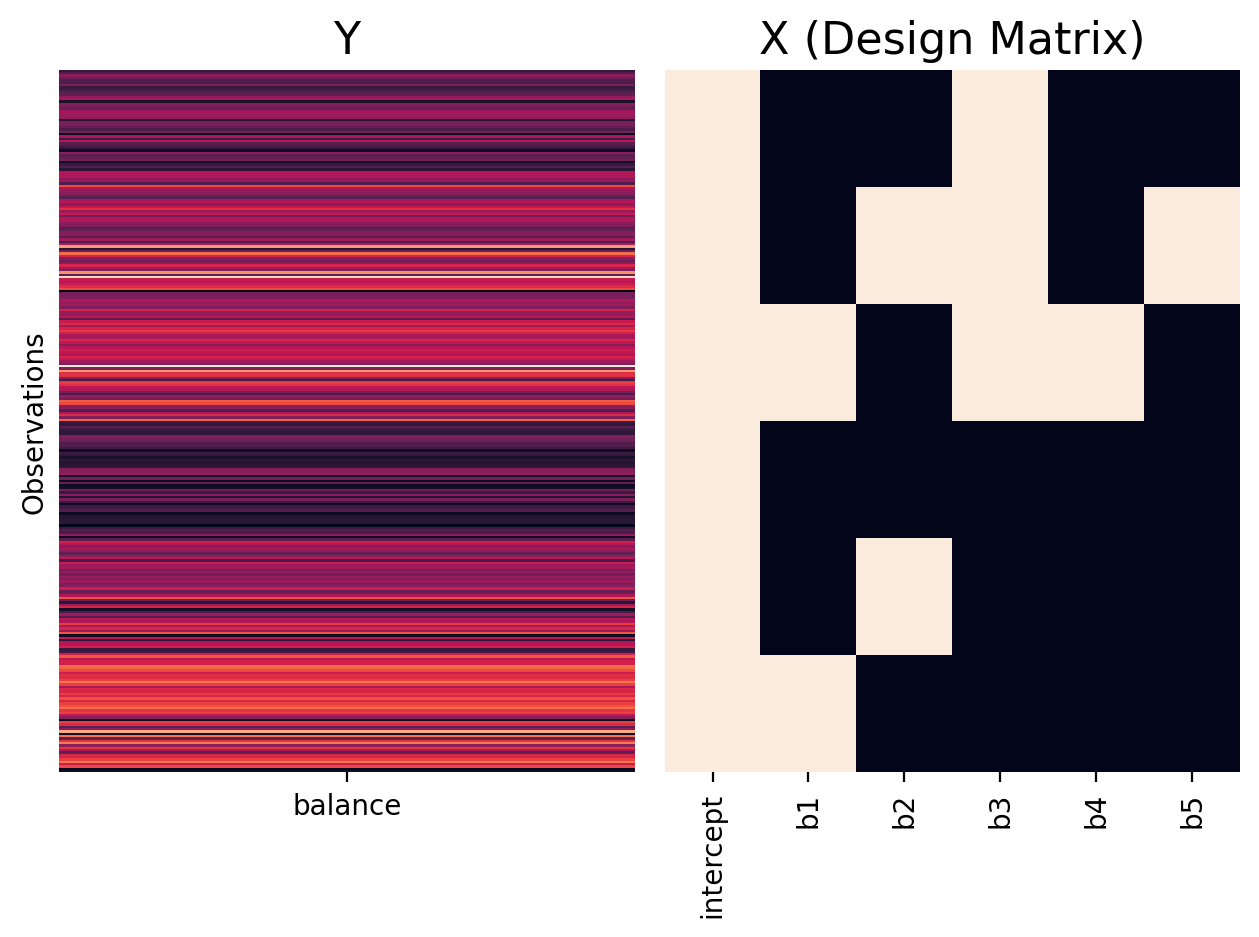

In [18]:
twoway_treatment = ols('balance ~ C(hand) * C(skill)', data=df.to_pandas())
plot_design_matrix(twoway_treatment, plot_names=['intercept','b1','b2','b3','b4','b5'])

If we add up the rows of our design matrix, ignoring the intercept, our columns do **not** sum to zero!

In [19]:
twoway_treatment.exog.sum(axis=0)

array([300., 100., 100., 150.,  50.,  50.])

We can also see this by inspecting the coding matrix that `ols` is using like we did in a previous notebook. This shows the mapping between each level of our categorical predictor and the corresponding reprsentation in the model, like a mini design-matrix. 

You can see that it matches the design matrix above (without the intercept)

In [20]:
from patsy.contrasts import Treatment

# All dummy-coded levels of our 2 categorical variables
levels = twoway_treatment.exog_names[1:]

# Generate the coding matrix
treatment_codes = Treatment().code_with_intercept(levels).matrix
treatment_codes

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

And that it fails out first requirement: rows sum-to-zero

In [21]:
treatment_codes.sum(axis=0)

array([1., 1., 1., 1., 1.])

And our second requirement: the overall sum across columns should be zero

In [22]:
treatment_codes.sum(axis=1).sum()

np.float64(5.0)

Let's compare this to *deviation/sum* coding

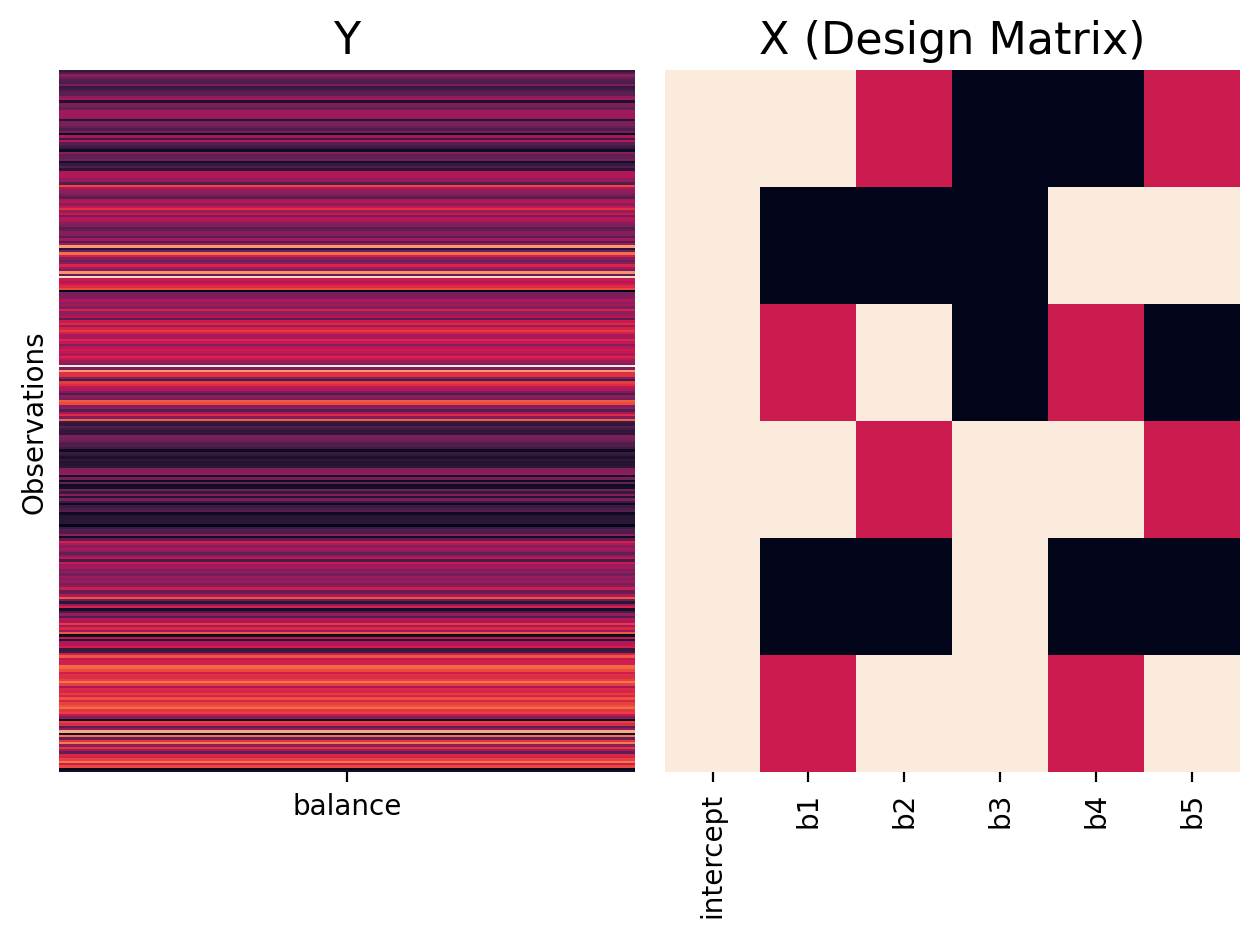

In [23]:
twoway_sum = ols('balance ~ C(hand, Sum) * C(skill, Sum)', data=df.to_pandas())
plot_design_matrix(twoway_sum, plot_names=['intercept','b1','b2','b3','b4','b5'])

Again we can check out the model matrix and see it how it maps the different levels of our categorical predictors to numerical values:

In [24]:
from patsy.contrasts import Sum

# All sum-coded levels of our 2 categorical variables
levels = twoway_sum.exog_names[1:]

# Generate the coding matrix
sum_codes = Sum().code_without_intercept(levels).matrix
sum_codes

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.],
       [-1., -1., -1., -1.]])

We can see that this scheme **is a valid contrast** because both rows and sum of columns equal 0:

In [25]:
sum_codes.sum(axis=0)

array([0., 0., 0., 0.])

In [26]:
sum_codes.sum(axis=1).sum()

np.float64(0.0)

### Challenge
Using the examples above and the starter code below, can you check if the *polynomial* scheme is a **valid contrast**?

*Note: often in python you'll see very small number written using scientific-notation like `-2.22044605e-16`. For all intent-and-purposes, this is the **same as 0** and is due to the way that your computer (and Python) represents the precision of floating-point numbers.*

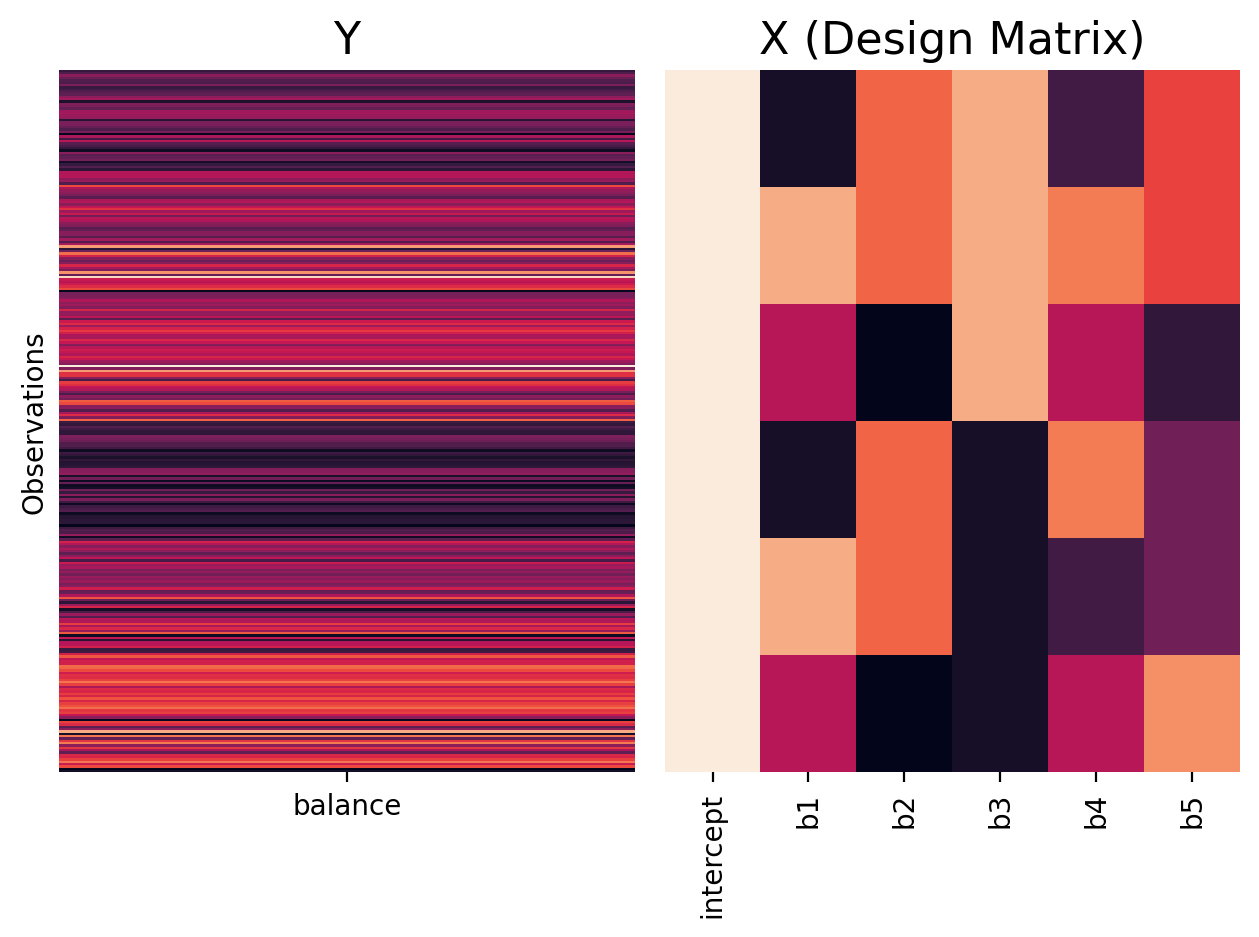

In [27]:
# Define model and plot design matrix here
# Solution
twoway_poly = ols('balance ~ C(hand, Poly) * C(skill, Poly)', data=df.to_pandas())
plot_design_matrix(twoway_poly, plot_names=['intercept','b1','b2','b3','b4','b5'])

In [28]:
# Solution
from patsy.contrasts import Poly

# Fill in with your model's design matrix
levels = twoway_poly.exog_names[1:]

# Generate the coding matrix
poly_codes = Poly().code_without_intercept(levels).matrix

In [29]:
# Your code checking validity here
# Solution
poly_codes.sum(axis=0).round(5)

array([ 0., -0.,  0., -0.])

In [30]:
poly_codes.sum(1).sum().round(5)

np.float64(-0.0)

### Type III sums of squares - valid inferences with unbalanced designs

The other requirement for a valid ANOVA is to know what's refered to as "type III sums of squares." This isn't technically a requirement but more of *default practice* in Psychology and most other social science because of its ability to handle **unbalanced designs with interactions**. 

Fisher's original formulation of ANOVA assumed that each combination of factor levels had the **same number of observations**. In experimental terms you might say you have the same $n$ in each "cell" of your design. When running a factorial ANOVA model with *different* $n$ in each cell, the type III method will partition variance for each factor in the way that you expect:

$$ 
SS(A | B, AB)\  \text{for independent variable A} \\
SS(B | A, AB)\  \text{for independent variable B} \\
$$

In other words it will calculate the *change in model error* when adding factor A accounting for both factors B *and* the interaction between A and B. Intuitively, you can think of this as the same interpretation as when we interpret our parameter estimates: the *unique variance* of predictor `a` when accounting for the other predictors `b` and their interactions `a*b`.

In other types of SS calculations (I and II) the *order* in which factors are entered into the model *changes* the results! This is **almost never what you want in practice**, so we won't go into the details of these calculations. Instead you can check out this [article](https://mcfromnz.wordpress.com/2011/03/02/anova-type-iiiiii-ss-explained/) for a more detailed explanation with code examples in R.

In your day-to-day work **always prefer type III sums-of-squares** which you can calculate by making sure to `typ=3` with `anova_lm`

### Mini-Exercise

Imagine you were running a replication of the poker study and you didn't quite get a chance to finish collecting the full set of data. Using the data we've loaded for you in the next cell complete the following exercises:

In [31]:
# Load incomplete data
df_inc = pl.read_csv('./data/poker-tidy-incomplete.csv')
df_inc.head()

skill,hand,limit,balance
str,str,str,f64
"""average""","""bad""","""no-limit""",7.84
"""expert""","""bad""","""fixed""",8.36
"""expert""","""good""","""no-limit""",15.95
"""average""","""neutral""","""fixed""",11.89
"""expert""","""bad""","""fixed""",11.04


Let's just focus on the `skill` and `hand` variables. How many observations per *cell* of the design in these data? And how does this compare to the original data (`df` variable)?

In [32]:
# Solution
df_inc.group_by(['hand','skill']).len()

hand,skill,len
str,str,u32
"""neutral""","""expert""",37
"""bad""","""expert""",44
"""bad""","""average""",42
"""good""","""average""",38
"""neutral""","""average""",39
"""good""","""expert""",40


In [33]:
# Solution
df.group_by(['hand','skill']).len()

hand,skill,len
str,str,u32
"""bad""","""expert""",50
"""neutral""","""average""",50
"""bad""","""average""",50
"""neutral""","""expert""",50
"""good""","""expert""",50
"""good""","""average""",50


Below we've estimated a model with the same predictors `hand` and `skill`, input to the model in two different orders. For some reason the F-statistics and `mean_sq` (error) of each factor are different between the models.

Can you figure out why? What can you change so that the order doesn't matter?

*We need to use **type 3** sums of squares*

In [34]:
hand_skill_treatment = ols('balance ~ C(hand) + C(skill)', data=df_inc.to_pandas()).fit()
anova_lm(hand_skill_treatment, typ=1).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(hand),2.0,1972.7168,986.3584,59.4160,0.0000
C(skill),1.0,22.9502,22.9502,1.3825,0.2409
Residual,236.0,3917.8128,16.6009,NaN,NaN


In [35]:
skill_hand_treatment = ols('balance ~ C(skill) + C(hand)', data=df_inc.to_pandas()).fit()
anova_lm(skill_hand_treatment, typ=1).round(4)

,df,sum_sq,mean_sq,F,PR(>F)
C(skill),1.0,21.2849,21.2849,1.2822,0.2586
C(hand),2.0,1974.3820,987.1910,59.4661,0.0000
Residual,236.0,3917.8128,16.6009,NaN,NaN


In [36]:
# Solution
anova_lm(hand_skill_treatment, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1968.384433,1.0,118.570935,1.224542e-22
C(hand),1974.382034,2.0,59.466108,1.220272e-21
C(skill),22.950190,1.0,1.382466,2.408662e-01
Residual,3917.812805,236.0,NaN,NaN


In [37]:
# Solution
anova_lm(skill_hand_treatment, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,1968.384433,1.0,118.570935,1.224542e-22
C(skill),22.950190,1.0,1.382466,2.408662e-01
C(hand),1974.382034,2.0,59.466108,1.220272e-21
Residual,3917.812805,236.0,NaN,NaN


Looking back at either model, it turns out we may not actually be calculating a **valid ANOVA** based on our coding scheme...

Fit a new model that estimates a valid ANOVA. Compare the **F statistics** of this model and the previous two models. What do you notice?

*The F-stat for `hand` matches `skill_hand_treatment` and the F-stat for `skill` matches `hand_skill_treatment` because type I SS is *sequential* so it first accounts for variance from the first entered term before calculating remaining variance for the second. Type III does this automatically, calculating **unique variance** for each factor irrespective of order!

In [38]:
# Solution
skill_hand_sum = ols('balance ~ C(skill,Sum) + C(hand,Sum)', data=df_inc.to_pandas()).fit()
anova_lm(skill_hand_treatment, typ=3).round(4)

,sum_sq,df,F,PR(>F)
Intercept,1968.3844,1.0,118.5709,0.0000
C(skill),22.9502,1.0,1.3825,0.2409
C(hand),1974.3820,2.0,59.4661,0.0000
Residual,3917.8128,236.0,NaN,NaN


## Additional Coding Systems for Categorical Variables

We've only been focusing on the 3 most common coding schemes that you'll use in practice:
- treatment (not valid for ANOVA)
- deviation (valid for ANOVA)
- polynomial (valid for ANOVA)

Below we've linked to a few other resources that cover additional coding schemes that you may consider in practice. 
- [Coding Systems for Categorical Variables](https://stats.oarc.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2/#DEVIATION%20EFFECT%20CODING) *conceptual overview, but examples are in R*
- [Contrasts in StatsModels](https://www.statsmodels.org/stable/contrasts.html) *Shorter Python version of the guide above*
- [How to use different coding schemes in formulas](https://patsy.readthedocs.io/en/latest/API-reference.html#categorical-coding-ref)

In a later notebook we'll explore how to **parameterize** our model to test specific planned comparisons and to follow up an estimate with additional **post-hoc** comparisons